In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import random
from IPython import display
from sklearn import datasets, preprocessing
import numpy as np

In [2]:
torch.manual_seed(137)
np.random.seed(239)
torch.cuda.manual_seed(179)

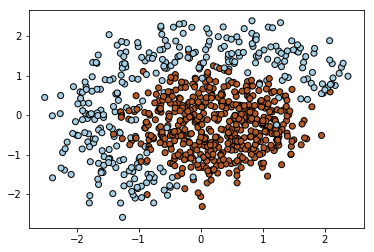

In [3]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = (y==1) | (X[:,1] > X[:,0] - 0.5)

X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
plt.show()

X, y = torch.FloatTensor(X), torch.FloatTensor(y)

In [4]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


def visualize(X, y, w, loss, n_iter):
    plt.clf()
    xy = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    Z = classify(xy, w)

    Z = Z.numpy()
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())


In [5]:
def expand(X):
    prod = X[:,0] * X[:,1]
    prod = prod.unsqueeze(1)
    oness = torch.ones_like(X[:, 0])
    oness = oness.unsqueeze(1)
    res = torch.cat([X, X ** 2, prod, oness], dim=1)
    return torch.FloatTensor(res)

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    return np.sign(torch.mv(expand(X), w))

In [6]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    return np.average(np.maximum(0, 1 - y * torch.mv(expand(X), w)))


def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """

    # Your code here
    return torch.matmul(((1 - y * torch.mv(expand(X), w)) > 0).float() * (-y), expand(X))

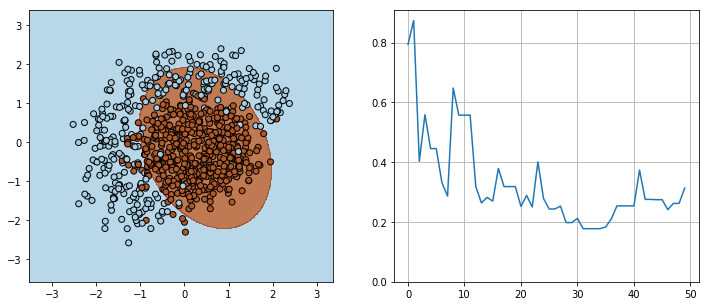

In [7]:
def gd():
    w = torch.Tensor([1, 0, 0, 0, 0, 0])

    alpha = 0.2

    n_iter = 50
    batch_size = 4
    loss = np.zeros(n_iter)
    plt.figure(figsize=(12, 5))
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = compute_loss(X, y, w)
        # visualize(X[ind, :], y[ind], w, loss, n_iter)

        w = w - alpha * compute_grad(X[ind, :], y[ind], w)

    print(w.shape)
    visualize(X, y, w, loss, n_iter)
    plt.clf()
gd()

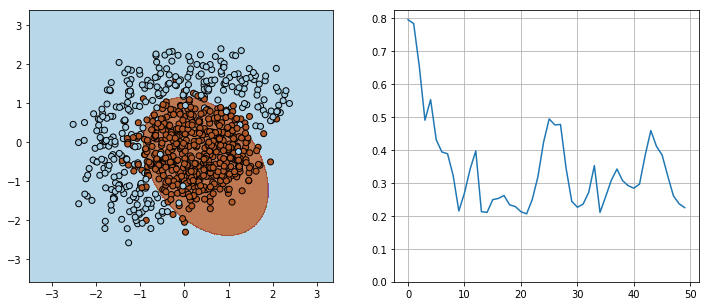

In [8]:
def momentum_gd():
    w = torch.Tensor([1, 0, 0, 0, 0, 0])

    alpha = 0.2 # learning rate
    mu = 0.6 # momentum

    v = torch.zeros_like(w)

    n_iter = 50
    batch_size = 4
    loss = np.zeros(n_iter)
    plt.figure(figsize=(12, 5))
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = compute_loss(X, y, w)
        # visualize(X[ind, :], y[ind], w, loss, n_iter)

        v = mu * v - alpha * compute_grad(X[ind, :], y[ind], w)
        w += v

    visualize(X, y, w, loss, n_iter)
    plt.clf()
momentum_gd()

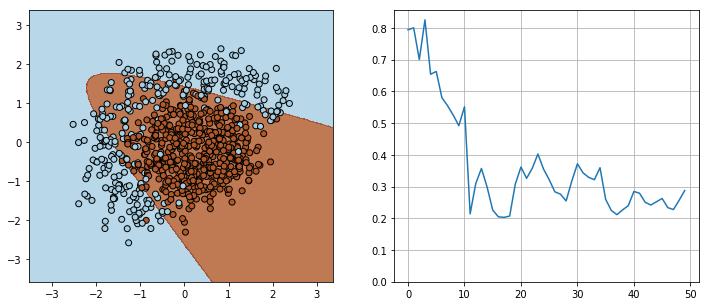

In [17]:
def nesterov_gd():
    w = torch.Tensor([1, 0, 0, 0, 0, 0])

    alpha = 0.2
    mu = 0.6

    v = torch.zeros_like(w)

    n_iter = 50
    batch_size = 4
    loss = np.zeros(n_iter)
    plt.figure(figsize=(12, 5))
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = compute_loss(X, y, w)
        #     visualize(X[ind,:], y[ind], w, loss, n_iter)


        w += mu * v
        
        grad = compute_grad(X[ind, :], y[ind], w)
        
        v = mu * v - alpha * grad
        w -= alpha * grad


    visualize(X, y, w, loss, n_iter)
    plt.clf()
nesterov_gd()

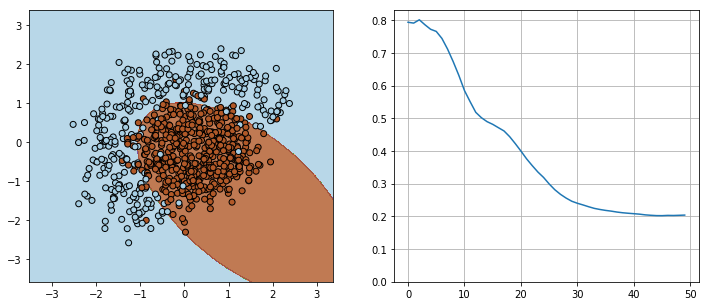

In [20]:
def adam_gd():
    w = torch.Tensor([1, 0, 0, 0, 0, 0])

    alpha = 0.2
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8

    m = torch.zeros_like(w)
    v = torch.zeros_like(w)

    n_iter = 50
    batch_size = 4
    loss = np.zeros(n_iter)
    plt.figure(figsize=(12, 5))
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = compute_loss(X, y, w)

        grad = compute_grad(X[ind, :], y[ind], w)

        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * torch.dot(grad, grad)

        m_corr = m / (1 - beta1 ** (i + 1))
        v_corr = v / (1 - beta2 ** (i + 1))

        w -= alpha / (v_corr ** 0.5 + eps) * m_corr

    visualize(X, y, w, loss, n_iter)
    plt.clf()
adam_gd()